# 1. Data Preprocessing 

#### 1. Load the raw dataset

When loading the dataset skip the first row since it contains metadata that is not valuable for the later steps. Let's saved the new dataframe to a csv file then.

In [234]:
import pandas as pd

# Dataset file path
inputPath = 'data/dataset.csv'

# Read the dataset, skip the first row which contains metadata
data = pd.read_csv(inputPath, sep=',', skiprows=1) 

# Save the new dataset
outputPath = "data/dataset-version-1.csv"
data.to_csv(outputPath, index=False)

#### 2. Load the newly created dataset-version-1.csv to a spark session.

All the next preprocessing tasks will be executed with Spark.

In [235]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# New Spark Session
spark = SparkSession.builder \
    .appName("NBA Player Performance Prediction") \
    .getOrCreate()

# Load the dataset
inputPath = "data/dataset-version-1.csv"
data = spark.read.csv(inputPath, header=True, inferSchema=True)

# Show the dataset
data.show()

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+-----+-----------+--------------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME|SCORE|SCOREMARGIN|  VISITORDESCRIPTION|
+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+

After going through the dataset, we can see that there are many missing values. We will be handling those missing values in the next steps.

#### 3. Drop rows where "SCORE" column is empty

Before executing any data cleaning steps, we need to get an idea about the dimensions about this dataset. Therefore let's create a helper function to read the dimensions of the dataset. 

In [236]:
# Helper function to get the dimensions of a given dataset
def show_dataset_dimensions(df, message):
    """
    Displays the dimensions of a given dataframe along with a message.

    Parameters:
    - df : Dataframe
    - message : Custom message
    """
    # Get dimensions
    num_rows = df.count()
    num_columns = len(df.columns)

    # Print dimensions
    print("Dataset consists of", num_rows, "rows and", num_columns, "columns ", message)

SCORE column is one of the most important columns in the dataset for the given task. Therefore we need to clean that column first. There are many missing values in this column, therefore we will remove all the rows where SCORE column is empty in the next steps. 

In [237]:
# Show the dimensions before cleaning
show_dataset_dimensions(data, "before cleaning")

# Remove rows where "SCORE" column is empty 
cleaned_data = data.filter(col('SCORE').isNotNull())

# Show the dimensions after cleaning
show_dataset_dimensions(cleaned_data, "after cleaning")

Dataset consists of 537157 rows and 27 columns  before cleaning
Dataset consists of 137590 rows and 27 columns  after cleaning


#### 4. Identify valuable coloumns from the dataset.

We have 537,157 rows in the initial dataset. After performing the above cleaning step, we have 137,590 rows remaining with 27 columns.

The next step is to extract the important coloumns in the dataset that are relevant for the task. After going through the dataset manually, below columns seems to be the valuable among others. Therefore will filter only these columns and proceed with them in the next steps.

In [238]:
# Relevant columns selected
selected_columns = [
    'GAME_ID', 'PERIOD', 'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_NICKNAME',
    'PLAYER1_TEAM_ID', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_NICKNAME',
    'PLAYER2_TEAM_ID', 'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_NICKNAME',
    'PLAYER3_TEAM_ID', 'SCORE',
]

# Dataset with relevant columns selected
cleaned_data = cleaned_data.select(*selected_columns)

# Show the dimensions before cleaning
show_dataset_dimensions(cleaned_data, "after cleaning")

# Show a sample of cleaned data
cleaned_data.show()

Dataset consists of 137590 rows and 15 columns  after cleaning
+--------+------+----------+---------------+---------------------+---------------+----------+---------------+---------------------+---------------+----------+------------+---------------------+---------------+-------+
| GAME_ID|PERIOD|PLAYER1_ID|   PLAYER1_NAME|PLAYER1_TEAM_NICKNAME|PLAYER1_TEAM_ID|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_NICKNAME|PLAYER2_TEAM_ID|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_NICKNAME|PLAYER3_TEAM_ID|  SCORE|
+--------+------+----------+---------------+---------------------+---------------+----------+---------------+---------------------+---------------+----------+------------+---------------------+---------------+-------+
|20001116|     1|       947|  Allen Iverson|                76ers|  1.610612755E9|         0|           NULL|                 NULL|           NULL|         0|        NULL|                 NULL|           NULL|  2 - 0|
|20001116|     1|       193|  Anthony Mason|                 Heat

#### 5. Handle missing values in the coloumns.

After the above cleaning process, we have only 15 columns there to work with.

Let's identify the missing values in the dataset as the next step. Let's identify the columns where all values are empty, null or na. These columns will not help for our task. Therefore after identifying, we can remove them from the dataset.

In [239]:
from pyspark.sql.functions import col

# Show the dimensions before cleaning
show_dataset_dimensions(cleaned_data, "before cleaning")

from pyspark.sql.functions import col

# Function to identidy columns in a dataset where all values are null, 'NA', or empty, and drop those columns from the dataset
def drop_all_null_columns(dataframe):
    """
    Identify columns in given dataframe where all values are null, 'NA', or empty strings
    and remove those columns from the dataframe.

    Parameters:
    - dataframe : Dataframe

    Returns:
    - tuple
        A tuple containing:
        - The cleaned dataframe.
        - List of column names that were removed

    """
    # Count the number of null, 'na' or empty values in every column
    null_counts = {
        column: dataframe.filter(
            (col(column).isNull()) | (col(column) == "NA") | (col(column) == "")
        ).count()
        for column in dataframe.columns
    }

    # Identify columns where all rows are null, 'na', or empty
    all_null_columns = [column for column, null_count in null_counts.items() if null_count == dataframe.count()]

    # Drop those columns
    cleaned_data = dataframe.drop(*all_null_columns)

    return cleaned_data, all_null_columns


# Cleaned data and list of columns to be dropped
cleaned_data, dropped_columns = drop_all_null_columns(cleaned_data)

# Print the columns that were dropped
print("Columns with all null, 'NA', or empty values:", dropped_columns)

# Show the dimensions before cleaning
show_dataset_dimensions(cleaned_data, "after cleaning")

Dataset consists of 137590 rows and 15 columns  before cleaning
Columns with all null, 'NA', or empty values: ['PLAYER3_NAME', 'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ID']
Dataset consists of 137590 rows and 12 columns  after cleaning


As we can see below columns contains only null, na or empty values,

* PLAYER3_NAME
* PLAYER3_TEAM_NICKNAME
* PLAYER3_TEAM_ID

All above columns were dropped from the database. Before this cleaning process we had 15 columns remaining. Now we have 12 coloumns remaining in the dataset.

Since most of the columns that are relevant to "Player 3" are dropped from the dataset, we can also remove the 'PLAYER3_ID' as well since only PLAYER3_ID column alone does not provide any valuable insights.

In [221]:
# Show the dimensions before cleaning
show_dataset_dimensions(cleaned_data, "before cleaning")

# Drop the PLAYER3_ID column
cleaned_data = cleaned_data.drop("PLAYER3_ID")

# Show the dimensions before cleaning
show_dataset_dimensions(cleaned_data, "after cleaning")

Dataset consists of 137590 rows and 12 columns  before cleaning
Dataset consists of 137590 rows and 11 columns  after cleaning


After dropping the 'PLAYER3_ID' column, we have only 11 coloumns remaining in the dataset.

#### 6. Process the SCORE coloumn further.

Next let's process the "SCORE" coloumn. The score is saved the format like this: 13 - 10. If the score value does not follow this format, let's remove that row first. Then we can extract these scores to 2 different colomns saying "TEAM1_SCORE", and "TEAM2_SCORE". After that we can remove the "SCORE" column.

In [222]:
from pyspark.sql.functions import col, regexp_extract

# Remove rows where SCORE does not follow the "number - number" format
valid_score_data = cleaned_data.filter(cleaned_data.SCORE.rlike(r"^\d+\s*-\s*\d+$"))

# Extract scores into two separate columns: TEAM1_SCORE and TEAM2_SCORE
processed_data = valid_score_data.withColumn("TEAM1_SCORE", regexp_extract(col("SCORE"), r"^(\d+)\s*-\s*\d+$", 1)) \
                                 .withColumn("TEAM2_SCORE", regexp_extract(col("SCORE"), r"^\d+\s*-\s*(\d+)$", 1))

# Cast the extracted scores to integer
processed_data = processed_data.withColumn("TEAM1_SCORE", col("TEAM1_SCORE").cast("integer")) \
                               .withColumn("TEAM2_SCORE", col("TEAM2_SCORE").cast("integer"))

# Drop the original SCORE column
processed_data = processed_data.drop("SCORE")

# Show the processed dataset
processed_data.show()

# Show the dimensions before cleaning
show_dataset_dimensions(cleaned_data, "before cleaning")

# Show the dimensions before cleaning
show_dataset_dimensions(processed_data, "after cleaning")

+--------+------+----------+---------------+---------------------+---------------+----------+---------------+---------------------+---------------+-----------+-----------+
| GAME_ID|PERIOD|PLAYER1_ID|   PLAYER1_NAME|PLAYER1_TEAM_NICKNAME|PLAYER1_TEAM_ID|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_NICKNAME|PLAYER2_TEAM_ID|TEAM1_SCORE|TEAM2_SCORE|
+--------+------+----------+---------------+---------------------+---------------+----------+---------------+---------------------+---------------+-----------+-----------+
|20001116|     1|       947|  Allen Iverson|                76ers|  1.610612755E9|         0|           NULL|                 NULL|           NULL|          2|          0|
|20001116|     1|       193|  Anthony Mason|                 Heat|  1.610612748E9|         0|           NULL|                 NULL|           NULL|          2|          2|
|20001116|     1|       248|   George Lynch|                76ers|  1.610612755E9|       727|      Eric Snow|                76ers|  1.61061

After that step, we have 137,590 rows and 12 columns remaining to work with.

#### 7. Identify the Teams participated for each game.

Next let's identify the the Teams participated for each game. We can store Team A and Team B names in Team1_Name and Team2_Name.

In [240]:
from pyspark.sql.functions import col, collect_set, first, udf, lit
from pyspark.sql.types import StringType

# Step 1: Identify Team1_Name for each GAME_ID
team1_name_df = processed_data.groupBy("GAME_ID").agg(
    first("PLAYER1_TEAM_NICKNAME", ignorenulls=True).alias("Computed_Team1_Name")
)

# Step 2: Identify Team2_Name for each GAME_ID
# Collect unique team nicknames per GAME_ID
distinct_teams_df = processed_data.groupBy("GAME_ID").agg(
    collect_set("PLAYER1_TEAM_NICKNAME").alias("Distinct_Teams")
)

# Define UDF to determine Team2_Name
@udf(StringType())
def find_opponent_team(distinct_teams, team1_name):
    return next((team for team in distinct_teams if team != team1_name), None)

distinct_teams_df = distinct_teams_df.join(team1_name_df, on="GAME_ID", how="left")
distinct_teams_df = distinct_teams_df.withColumn(
    "Computed_Team2_Name", find_opponent_team(col("Distinct_Teams"), col("Computed_Team1_Name"))
)

# Step 3: Create 'Team1_Name' and 'Team1_Name 'columns if they don't exist
if "Team1_Name" not in processed_data.columns:
    processed_data = processed_data.withColumn("Team1_Name", lit(None).cast(StringType()))
if "Team2_Name" not in processed_data.columns:
    processed_data = processed_data.withColumn("Team2_Name", lit(None).cast(StringType()))

# Step 4: Update the Team1_Name and Team2_Name columns
processed_data = processed_data.drop("Team1_Name", "Team2_Name")
processed_data = processed_data.join(
    team1_name_df.select("GAME_ID", col("Computed_Team1_Name").alias("Team1_Name")), 
    on="GAME_ID", how="left"
)
processed_data = processed_data.join(
    distinct_teams_df.select("GAME_ID", col("Computed_Team2_Name").alias("Team2_Name")), 
    on="GAME_ID", how="left"
)

# Show the processed dataset
processed_data.show()

+--------+------+----------+----------------+---------------------+---------------+----------+-------------+---------------------+---------------+-----------+-----------+-----------------+------------------+----------+-----+------------+------------+-----------+----------+----------+
| GAME_ID|PERIOD|PLAYER1_ID|    PLAYER1_NAME|PLAYER1_TEAM_NICKNAME|PLAYER1_TEAM_ID|PLAYER2_ID| PLAYER2_NAME|PLAYER2_TEAM_NICKNAME|PLAYER2_TEAM_ID|TEAM1_SCORE|TEAM2_SCORE|Winning_Team_Name|Winning_Team_Score|Team_A_Won|label|Team_B_Score|Total_Points|   features|Team1_Name|Team2_Name|
+--------+------+----------+----------------+---------------------+---------------+----------+-------------+---------------------+---------------+-----------+-----------+-----------------+------------------+----------+-----+------------+------------+-----------+----------+----------+
|20000001|     1|       689|    Theo Ratliff|                76ers|  1.610612755E9|         0|         NULL|                 NULL|           NULL

After the above step, we have identified the participating teams for each game. 

#### 8. Indentify Winning Team and Winning Team Score

Let's extract the Winning Team and Winning Team Score and add it to the dataframe. 

In [241]:
from pyspark.sql.functions import col, max, when, lit

# Step 1: Group by GAME_ID and find the maximum scores for Team 1 and Team 2
scores_df = processed_data.groupBy("GAME_ID").agg(
    max("TEAM1_SCORE").alias("Max_Team1_Score"),
    max("TEAM2_SCORE").alias("Max_Team2_Score")
)

# Step 2: Add a new column for the winning team
scores_df = scores_df.withColumn(
    "Winning_Team",
    when(col("Max_Team1_Score") > col("Max_Team2_Score"), lit("Team1"))
    .when(col("Max_Team2_Score") > col("Max_Team1_Score"), lit("Team2"))
    .otherwise(lit("Draw"))  # In case of a tie
)

# Step 3: Map the winning team to Team1_Name or Team2_Name and store the winning score
scores_df = scores_df.join(
    processed_data.select("GAME_ID", "Team1_Name", "Team2_Name").distinct(),
    on="GAME_ID",
    how="left"
)

scores_df = scores_df.withColumn(
    "Winning_Team_Name",
    when(col("Winning_Team") == "Team1", col("Team1_Name"))
    .when(col("Winning_Team") == "Team2", col("Team2_Name"))
    .otherwise(lit("No Winner"))  # For cases with no clear winner
).withColumn(
    "Winning_Team_Score",
    when(col("Winning_Team") == "Team1", col("Max_Team1_Score"))
    .when(col("Winning_Team") == "Team2", col("Max_Team2_Score"))
    .otherwise(lit(None))  # No score for a tie
).select("GAME_ID", "Winning_Team_Name", "Winning_Team_Score")

# Step 4: Merge Winning_Team_Name and Winning_Team_Score into processed_data
processed_data = processed_data.join(
    scores_df,
    on="GAME_ID",
    how="left"
)

# Step 5: Sort by PERIOD within each GAME_ID
processed_data = processed_data.orderBy(col("GAME_ID"), col("PERIOD"))

# Step 6: Display the updated DataFrame
processed_data.show()

+--------+------+----------+----------------+---------------------+---------------+----------+-------------+---------------------+---------------+-----------+-----------+-----------------+------------------+----------+-----+------------+------------+-----------+----------+----------+-----------------+------------------+
| GAME_ID|PERIOD|PLAYER1_ID|    PLAYER1_NAME|PLAYER1_TEAM_NICKNAME|PLAYER1_TEAM_ID|PLAYER2_ID| PLAYER2_NAME|PLAYER2_TEAM_NICKNAME|PLAYER2_TEAM_ID|TEAM1_SCORE|TEAM2_SCORE|Winning_Team_Name|Winning_Team_Score|Team_A_Won|label|Team_B_Score|Total_Points|   features|Team1_Name|Team2_Name|Winning_Team_Name|Winning_Team_Score|
+--------+------+----------+----------------+---------------------+---------------+----------+-------------+---------------------+---------------+-----------+-----------+-----------------+------------------+----------+-----+------------+------------+-----------+----------+----------+-----------------+------------------+
|20000001|     1|       689|    Th

After above process,  we have the winning team and the score of the winning team in the dataframe.

# 2. Data Visualization

#### 1. Plot the score progression for the first game

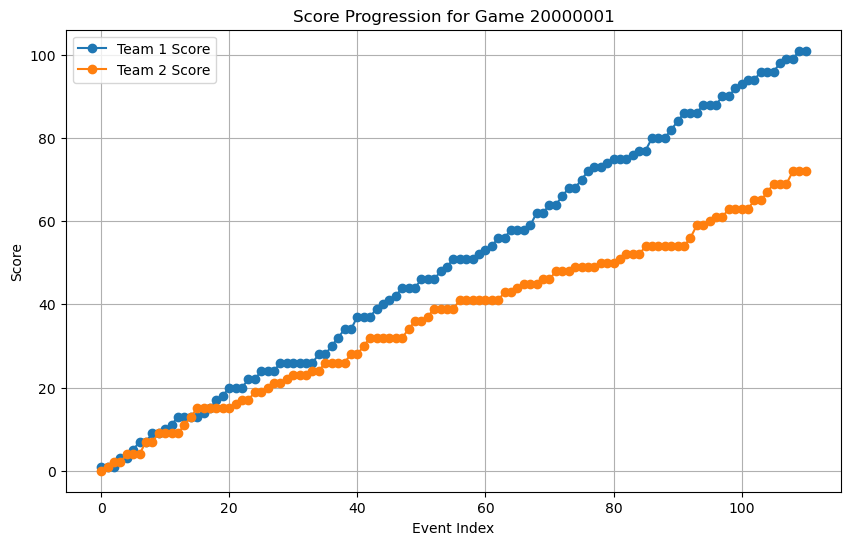

In [242]:
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt

def plot_score_progression(data: DataFrame, game_id: int):
    """
    Plot the score progression for a given game.

    Parameters:
    - data: PySpark DataFrame containing the game data.
    - game_id: The GAME_ID of the game to plot.
    """
    # Filter the dataframe for a given GAME_ID
    game_data = data.filter(data['GAME_ID'] == game_id).toPandas()

    # Plot the score progression
    plt.figure(figsize=(10, 6))
    plt.plot(game_data.index, game_data['TEAM1_SCORE'], label='Team 1 Score', marker='o')
    plt.plot(game_data.index, game_data['TEAM2_SCORE'], label='Team 2 Score', marker='o')
    plt.title(f'Score Progression for Game {game_id}')
    plt.xlabel('Event Index')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the scrore progression for the first game
game_id_example = processed_data.select("GAME_ID").first()["GAME_ID"]
plot_score_progression(processed_data, game_id_example)


#### 2. Plot the best 10 players who scored the most points in the tournament.

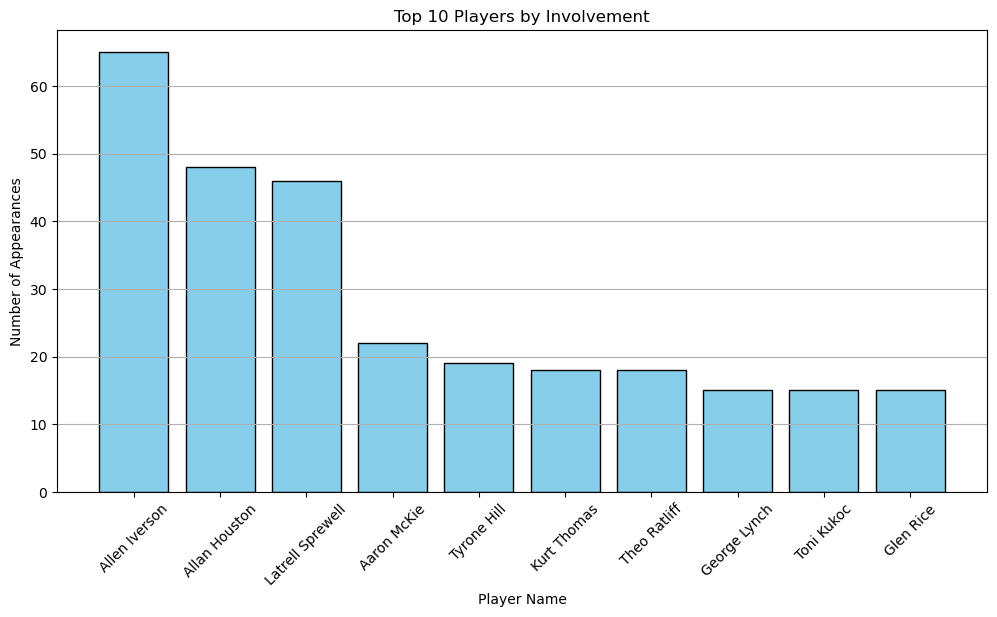

In [244]:
def plot_player_involvement(data):
    """
    Plot the top 10 players who score the most points.

    Parameters:
    - data: PySpark dataframe containing the game data.
    """
    # Handle missing values in PLAYER1_NAME coloumn
    filtered_data = data.filter(data['PLAYER1_NAME'].isNotNull())

    # Count occurrences of PLAYER1_NAME
    player_counts = (
        filtered_data.groupBy("PLAYER1_NAME")
        .count()
        .orderBy("count", ascending=False)
        .limit(10)  # top 10 players
        .toPandas()
    )

    # Plot the top 10 players
    plt.figure(figsize=(12, 6))
    plt.bar(player_counts['PLAYER1_NAME'], player_counts['count'], color='skyblue', edgecolor='black')
    plt.title('Top 10 Players by Involvement')
    plt.xlabel('Player Name')
    plt.ylabel('Number of Appearances')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Plot the top 10 players
plot_player_involvement(processed_data)

#### 3. Plot the quater by quater score trends for the tournament.

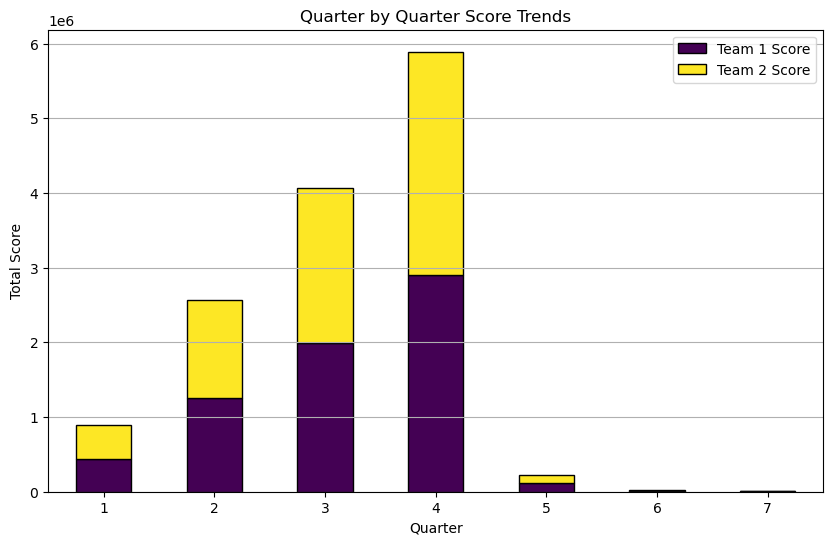

In [ ]:
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

def plot_quarter_trends(data):
    """
    Plot quarter by quarter score trends as a stacked bar chart.

    Parameters:
    - data: PySpark dataframe containing the game data.
    """
    # Group by PERIOD and aggregate the scores
    quarter_scores = (
        data.groupBy("PERIOD")
        .agg(
            _sum("TEAM1_SCORE").alias("TEAM1_SCORE"),
            _sum("TEAM2_SCORE").alias("TEAM2_SCORE")
        )
        .orderBy("PERIOD")  # quarters should be in order
        .toPandas()  # Convert to pandas for plotting
    )

    # Plot the stacked bar chart
    quarter_scores.plot(
        x="PERIOD",
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        colormap="viridis",
        edgecolor="black"
    )
    plt.title("Quarter by Quarter Score Trends")
    plt.xlabel("Quarter")
    plt.ylabel("Total Score")
    plt.legend(["Team 1 Score", "Team 2 Score"])
    plt.xticks(rotation=0)
    plt.grid(axis="y")
    plt.show()

# Plot quater by quater score trends
plot_quarter_trends(processed_data)

# 3. Model Building

## Objective:

* Predict the average points expected to be scored by a player in TeamA to win a match against TeamB.

## Steps:

1. Analyse the game history for Team A against Team B. 

2. Find the games that Team A has won against Team B. 

    a. Find the average total score that Team A scored in these games. Let’s say that score is called TeamA_Win_Match_Score.

3. Find the games that Team A lost against Team B. 

    a. Find the average total score that Team B scored in these games.  Let’s say that score is called TeamB_Win_Match_Score.

## Assumptions
1. In a future match against Team A and Team B, if Team A has to win, then Team A should score more that TeamA_Win_Match_Score and TeamB_Win_Match_Score. That should be the predicted winning score for Team A. Let’s say that is called Predicted_TeamA_Winning_Score.

2. Usually in a NBA game there are 15 player. To get the average score a player in Team A has to make, devide Predicted_TeamA_Winning_Score by 15.


In [228]:
from pyspark.sql.functions import col, when, avg, lit

# Step 1: Feature Engineering
def prepare_features(data, team_a, team_b):
    data = data.filter(
        ((col("Team1_Name") == team_a) & (col("Team2_Name") == team_b)) |
        ((col("Team1_Name") == team_b) & (col("Team2_Name") == team_a))
    )
    data = data.withColumn(
        "Team_A_Won",
        when(col("Winning_Team_Name") == team_a, lit(1)).otherwise(lit(0))
    )
    data = data.withColumn(
        "Team_A_Score", 
        when(col("Team1_Name") == team_a, col("TEAM1_SCORE")).otherwise(col("TEAM2_SCORE"))
    )
    data = data.withColumn(
        "Team_B_Score", 
        when(col("Team1_Name") == team_b, col("TEAM1_SCORE")).otherwise(col("TEAM2_SCORE"))
    )
    return data

In [229]:
# Step 2: Prepare the Dataset
team_a = "76ers"
team_b = "Knicks"

processed_data = prepare_features(processed_data, team_a, team_b)

In [230]:
from pyspark.ml.feature import VectorAssembler

# Step 3: Define Features and Target
feature_columns = ["Team_B_Score", "Total_Points"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

processed_data = processed_data.withColumn(
    "Total_Points", col("Team_A_Score") + col("Team_B_Score")
)
processed_data = assembler.transform(processed_data)

# Define the target variable (Team_A_Score for regression)
processed_data = processed_data.withColumnRenamed("Team_A_Score", "label")

In [231]:
from pyspark.ml.regression import LinearRegression

# Step 4: Train-Test Split
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train the Regression Model
lr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction")
lr_model = lr.fit(train_data)

24/12/13 20:42:58 WARN Instrumentation: [daccb21b] regParam is zero, which might cause numerical instability and overfitting.


In [232]:
from pyspark.ml.evaluation import RegressionEvaluator

# Step 6: Evaluate the Model
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.2f}")

Root Mean Squared Error (RMSE) on test data: 0.00


In [233]:
from builtins import max 
import math

# Step 7: Compute Predicted Average Points for Team A
team_a_win_match_score = processed_data.filter(col("Team_A_Won") == 1).agg(avg("label").alias("avg_score")).collect()[0][0]
team_b_win_match_score = processed_data.filter(col("Team_A_Won") == 0).agg(avg("Team_B_Score").alias("avg_score")).collect()[0][0]

predicted_team_a_winning_score = max(team_a_win_match_score, team_b_win_match_score)

# Average points per player
avg_points_per_player =int(math.ceil(predicted_team_a_winning_score / 15))

# Output Results
print(f"Predicted average points per player for {team_a} to win: {avg_points_per_player:.2f}")

Predicted average points per player for 76ers to win: 4.00
